# Syrtis Demonstration - Martian Environment
# Variations in Heat Loss over a Martian Day

This example shows another feature of Syrtis that allows for rapid calculation of many values - the `DayManager` tool. This initialises and runs a series of simulations for a single habitat geometry, each at a different time of a solar day. `DayManager` thus provides the ability to see how a habitat design will fare across an entire sol, rather than just at a static point in time. It also automatically corrects for atmospheric attenuation, reduced sunlight at higher latitudes and variability in daily temperature.

In [2]:
from syrtis import *
from syrtis.configuration import Configuration
from syrtis.solver import Solver
from syrtis.material import Solid, ConstrainedIdealGas
from syrtis.habitat import Habitat
import numpy as np
import matplotlib.pyplot as plt

### Setup and Configuration
The same geometry as the Mars Direct - Vertical HAB is used. Instead of the generic Martian equator location, one of SpaceX's proposed landing sites at Phlegra Montes is chosen.

In [3]:
# Materials definitions
# The absorbivity of perlite and air are assumed as 0.5 but are not required
aluminium = Solid("Aluminium", 247, 2700, 900, 0.15)
plastic = Solid("Generic plastic", 10, 1300, 1420, 0.5)

internal_air = ConstrainedIdealGas("STP CO2", 101325, 29, 0.71, 10.9e-6, 749, 0.0153)
martian_air = ConstrainedIdealGas("Martian ambient pressure CO2", 580, 44, 0.71, 10.9e-6, 749, 0.0153)

phlegra_montes_spacex = Configuration("Phlegra Montes landing site, SpaceX target",
 "constant temperature", 210, 0.2, 0.29, 210, 580, 5, "cross", 90, 90, 590, T_habitat=293)

In [4]:
HAB_vertical = Habitat(orientation="vertical", length=8, endcap_type="flat")

HAB_vertical.create_static_shell(internal_air, 4.400)
HAB_vertical.create_static_shell(aluminium, 4.8e-3)

HAB_vertical.create_static_shell(martian_air, 50e-3, parallel_thermal_resistance=8.5e-5)
# Parallel resistance corresponds to 1% of the cross-section being aluminium

HAB_vertical.create_static_shell(plastic, 12e-3)
HAB_vertical.create_static_shell(martian_air, 50e-3, parallel_thermal_resistance=8.4e-5)

HAB_vertical.create_static_shell(aluminium, 2e-3)

HAB_vertical.create_ground_level(thermal_resistance=1)
# Thermal resistance roughly corresponds to six aluminium landing legs, each 5m long and with 50cm2 area

## DayManager Creation

`DayManager` objects are created for both a winter and summer case

In [11]:
winter_data = DayManager(HAB_vertical, phlegra_montes_spacex, 49, 
    atmosphere_tau=0.3, latitude=35.25, areocentric_longitude=68,
    T_air_max=253, T_air_min=173, T_ground_max=228, T_ground_min=173, time_air_peak=14, time_ground_peak=12.5)

summer_data = DayManager(HAB_vertical, phlegra_montes_spacex, 49, 
    atmosphere_tau=0.3, latitude=35.25, areocentric_longitude=248,
    T_air_max=278, T_air_min=183, T_ground_max=253, T_ground_min=183, time_air_peak=14, time_ground_peak=12.5)

In [12]:
summer_configs, summer_heats, summer_reports = summer_data.run_all_configurations(verbose=True)

winter_configs, winter_heats, summer_reports = winter_data.run_all_configurations(verbose=True)

(0, 24.65)

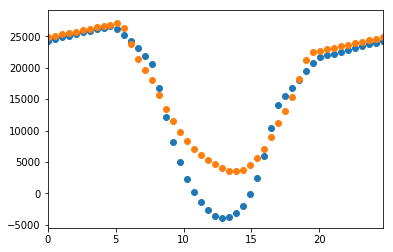

In [13]:
plt.scatter(summer_data.times, summer_heats, label="Summer")
plt.scatter(winter_data.times, winter_heats, label="Winter")
plt.xlim(0, 24.65)

(0, 24.65)

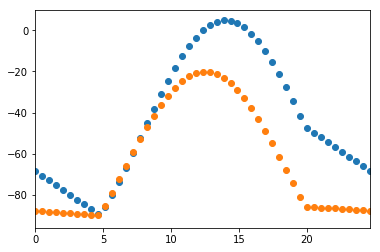

In [14]:
plt.scatter(summer_data.times, [i-273 for i in summer_data.T_airs])
plt.scatter(summer_data.times, [i-273 for i in summer_data.T_grounds])
plt.xlim(0, 24.65)

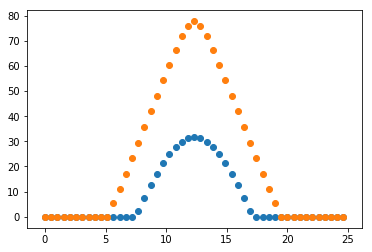

In [15]:
plt.scatter(summer_data.times, summer_data.solar_altitudes)
plt.scatter(winter_data.times, winter_data.solar_altitudes)

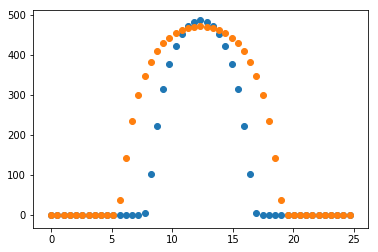

In [16]:
plt.scatter(summer_data.times, summer_data.solar_intensities)
plt.scatter(winter_data.times, winter_data.solar_intensities)

## Results

The initial results set is the power loss-temperature plot. These show the range of heat dissipations for a given internal wall temperature, based on an extended habitable range. This gives the surprising result - at noon, a vertically-oriented module will have relatively little heat flux for an optimal habitable temperature, presumably due to the influence of solar heating. This could very well present an issue! The life support alone for a habitat of this type could consume 20kW ([see Mars Life Support Systems, Rapp 2006]([http://marsjournal.org/contents/2006/0005/files/rapp_mars_2006_0005.pdf)). The power requirements of payloads/experiments could easily be double this, as established by the ISS which has 70kW of total power generation and an ECLSS power of TK kW. This shows that substantial heat rejection systems will be required for balancing heat loads during the Martian day.

### Breakdown of heat sources and sinks

The below code accesses the functionality of `syrtis.tools` to plot a "power balance chart" for the two configurations of Habitat. The downward stacked bar below zero shows sources of heat gain into the habitat - primarily direct and indirect solar gain. The upward stacked bar, which begins at some distance below the x-axis, shows the heat sinks present in the system. The most significant of these are radiative losses to the sky and ground, although convection is significant for both and ground conduction plays a reasonable role in the horizontal system. As can be seen, the larger radiative area of the vertical habitat counteracts the additional conductive term for the horizontal habitat: the soil acts as an effective insulator.

The ultimate height of the bar above the x-axis is the net heat flux from the habitat at $25\degree$ C. For a temperature which is stable in the steady state, this must be balanced with heating. Should this bar end up below zero, the habitat would be gaining heat from the environment and additional cooling would be required.